In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import netCDF4 as nc
import matplotlib.pyplot as plt
from tqdm import tqdm

#import seaborn as sns
import folium
#import National_Snow_Model as NSM
#import NSM_SCA
from datetime import datetime, timedelta
import os

import warnings
warnings.filterwarnings("ignore")

#set path directory
os.getcwd()
os.chdir('..')
cwd = os.getcwd()
cwd

C:\Users\rjohnson18\Anaconda3\envs\NSM_env\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


'C:\\Users\\rjohnson18\\Box\\CIROH\\SnowModeling\\Snow_Modeling_Group\\NSM_App_Deployment\\National-Snow-Model'

In [4]:
# Create Filepaths and dates
cwds = {
    "no_fSCA_Region_Pred": cwd+"/Predictions/NSM2018_no_fSCA_Region_Pred",
    "fSCA_RegionVal": cwd+"/Predictions/NSM2018_fSCA_RegionVal",
    "no_fSCA_RegionVal": cwd+"/Predictions/NSM2018_no_fSCA_RegionVal",
    "5000ftDomain_UpdatedCDEC": cwd+ "/Predictions/NSM2018_FullDomain_UpdatedCDEC"
       }

dates = [datetime(2018, 12, 24), datetime(2019, 4, 15), datetime(2019, 7, 22)]

# Creates GeoJSON exports

This code block runs the model, making the predictions.

In [35]:
#for cwd in cwds:
 #   for date in dates:
        # create SWE_Prediction class in the directory where the files are saved
  #      nsm = National_Snow_Model.SWE_Prediction(cwds[cwd], date.strftime('%Y-%m-%d'))

   #     nsm.Geo_df()  # create geodataframe from files

        # Export to GeoJSON
    #    nsm.SWE_gdf.to_file(cwds[cwd] + f'/NSM{date.strftime("%Y-%m-%d")}_{cwd}.geojson', driver='GeoJSON')

# os.system(f'say "your program has completely finished"')  # sometimes can take a while... only works on MacOS

# Combines Data from h5 files into a single DF

In [5]:
from datetime import date, timedelta

#Grab existing files based on water year
prev_year = '2018'

#input the new water year of choice
water_year = '2019'

prev_date = date(int(prev_year), 10, 1)
new_date = date(int(water_year), 7, 31)

#write code for CSV files

#for h5 files
Region_list = ['N_Sierras',
                       'S_Sierras_High',
                       'S_Sierras_Low',
                       #'Greater_Yellowstone',
                       #'N_Co_Rockies',
                       #'SW_Mont',
                       #'SW_Co_Rockies',
                       #'GBasin',
                       #'N_Wasatch',
                       #'N_Cascade',
                       #'S_Wasatch',
                       #'SW_Mtns',
                       #'E_WA_N_Id_W_Mont',
                       #'S_Wyoming',
                       #'SE_Co_Rockies',
                       #'Sawtooth',
                       #'Ca_Coast',
                       #'E_Or',
                       #'N_Yellowstone',
                       #'S_Cascade',
                       #'Wa_Coast',
                       #'Greater_Glacier',
                       #'Or_Coast'
                      ]

In [6]:
#can be altered to create list every n number of days by changing 7 to desired skip length
def daterange(start_date, end_date):
     for n in range(0, int((end_date - start_date).days) + 1, 7):
        yield start_date + timedelta(n)
        
def Region_id(df):
        # put obervations into the regions
    for i in tqdm(range(0, len(df))):

        # Sierras
        # Northern Sierras
        if -122.5 <= df['Long'][i] <= -119 and 39 <= df['Lat'][i] <= 42:
            loc = 'Sierras'
            df['Region'].iloc[i] = loc

        # Southern Sierras
        if -121.2 <= df['Long'][i] <= -117 and 35 <= df['Lat'][i] <= 39:
            loc = 'Sierras'
            df['Region'].iloc[i] = loc


In [8]:
#create empty list to store dates
datelist = []
#define start and end date for list of dates
start_dt = prev_date
end_dt = new_date
#append dates to list
for dt in daterange(start_dt, end_dt):
    #print(dt.strftime("%Y-%m-%d"))
    dt=dt.strftime('%Y-%m-%d')
    datelist.append(dt)


In [9]:
region_val = pd.read_pickle(cwd+"/Data/Processed/RegionVal.pkl")

superset = []

for region in region_val:
    superset.append(region_val[region])

superset = pd.concat(superset)
superset = superset.set_index('cell_id')

In [10]:
runs = {}

for cw in cwds:
    print(f"on {cw}")
    run = superset.copy()
    for date in tqdm(datelist):
        #print(f"on {date}")
        run[date] = 0
        for region in Region_list:
            tmp = pd.read_hdf(f"{cwds[cw]}/Predictions/predictions{date}.h5", key=region)
            tmp = tmp[[date]]
            run.update(tmp)
            # print(tmp.head())
    runs[cw] = run

on no_fSCA_Region_Pred


100%|██████████| 44/44 [00:04<00:00, 10.98it/s]


on fSCA_RegionVal


100%|██████████| 44/44 [00:04<00:00,  9.48it/s]


on no_fSCA_RegionVal


100%|██████████| 44/44 [00:04<00:00, 10.09it/s]


on 5000ftDomain_UpdatedCDEC


100%|██████████| 44/44 [00:03<00:00, 11.36it/s]


In [11]:
#Get Sierra Nevada predictions

for run in runs:
    runs[run]['Region'] = 'None'
    Region_id(runs[run])
    runs[run] = runs[run][runs[run]['Region'] =='Sierras']

100%|██████████| 20759/20759 [00:03<00:00, 6092.39it/s]


## Export to CSVs

In [12]:
clean = {}
for run in runs:
    clean[run] = runs[run].drop(columns=['Lat','Long', 'elevation_m', 'northness', 'Region'])
    clean[run] = clean[run].fillna(0)
    runs[run].to_csv(cwd+ "/Data/Processed/"+ run+ "_Sierras.csv")

## Plot Average watershed SWE over time

In [13]:
Spatial_Ave_df = pd.DataFrame()

for sim in clean:
    cleandf = pd.DataFrame(columns = clean[sim].columns)
    
    for col in clean[sim].columns:
        cleandf[col] = [clean[sim][col].mean()]
    Spatial_Ave_df[sim] = cleandf.T
Spatial_Ave_df.index = pd.to_datetime(Spatial_Ave_df.index)
Spatial_Ave_df     

,no_fSCA_Region_Pred,fSCA_RegionVal,no_fSCA_RegionVal,5000ftDomain_UpdatedCDEC
2018-10-01,0.257417,0.000000,0.485954,0.264913
2018-10-08,0.339799,0.073022,0.589773,0.383246
2018-10-15,0.423516,0.001118,0.686381,0.430446
2018-10-22,0.519185,0.072954,0.793146,0.558351
2018-10-29,0.636377,0.085357,0.920861,0.660286
2018-11-05,1.008836,0.000559,1.338580,0.990949
2018-11-12,1.327934,0.001245,1.747837,1.293720
2018-11-19,1.535416,0.004212,2.019275,1.487066
2018-11-26,2.357326,0.242418,2.919808,2.681498
2018-12-03,3.010350,0.856150,3.588950,3.804584


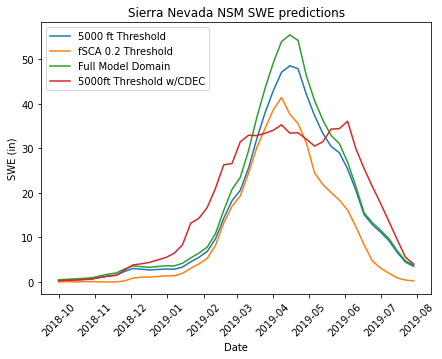

In [14]:
import matplotlib.dates as mdates

#make figure
fig, ax = plt.subplots(1,1, figsize=(7, 5))
ax.set_facecolor('white')

ax.plot(Spatial_Ave_df['no_fSCA_Region_Pred'], label = '5000 ft Threshold')
ax.plot(Spatial_Ave_df['fSCA_RegionVal'], label = 'fSCA 0.2 Threshold')
ax.plot(Spatial_Ave_df['no_fSCA_RegionVal'], label = 'Full Model Domain')
ax.plot(Spatial_Ave_df['5000ftDomain_UpdatedCDEC'], label = '5000ft Threshold w/CDEC')
ax.legend()
#ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,3)))
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

plt.setp(ax.get_xticklabels(), rotation=45) 
plt.ylabel("SWE (in)")
plt.xlabel("Date")
plt.title("Sierra Nevada NSM SWE predictions")
plt.savefig(cwd + "/Figures/Thresholds/2018-2019_SWE_in_Sierras.png", dpi=600, bbox_inches='tight')
plt.show()

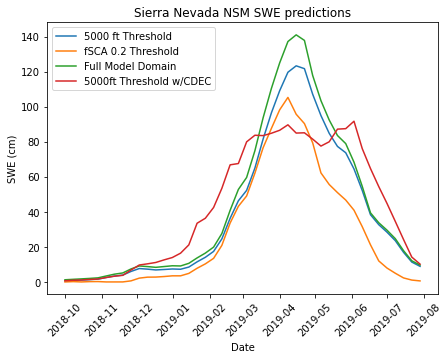

In [17]:
import matplotlib.dates as mdates

in_to_cm = 2.54

#make figure
fig, ax = plt.subplots(1,1, figsize=(7, 5))
ax.set_facecolor('white')

ax.plot(Spatial_Ave_df['no_fSCA_Region_Pred']*in_to_cm, label = '5000 ft Threshold')
ax.plot(Spatial_Ave_df['fSCA_RegionVal']*in_to_cm, label = 'fSCA 0.2 Threshold')
ax.plot(Spatial_Ave_df['no_fSCA_RegionVal']*in_to_cm, label = 'Full Model Domain')
ax.plot(Spatial_Ave_df['5000ftDomain_UpdatedCDEC']*in_to_cm, label = '5000ft Threshold w/CDEC')
ax.legend()
#ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,3)))
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

plt.setp(ax.get_xticklabels(), rotation=45) 
plt.ylabel("SWE (cm)")
plt.xlabel("Date")
plt.title("Sierra Nevada NSM SWE predictions")
plt.savefig(cwd + "/Figures/Thresholds/2018-2019_SWE_cm_Sierras.png", dpi=600, bbox_inches='tight')
plt.show()

In [23]:
#Get and add CDEC observations to SWE prediction plot
CDEC = {}

path = cwd+ '/Data/Pre_Processed_DA/WY2019/'
for x in os.listdir(path):
    if x.endswith(".csv"):
        CDEC[x] = pd.read_csv(path+x)
        CDEC[x] = CDEC[x][CDEC[x]['station_id'].str.contains('CDEC') ]
        CDEC[x].set_index('station_id', inplace = True)

In [24]:
CDEC_df = pd.DataFrame(index = CDEC['ground_measures_features_2019-03-04.csv'].index)

for key in CDEC.keys():
    df = CDEC[key]
    CDEC_df = pd.concat([CDEC_df, df])


In [25]:
pd.DataFrame.from_dict(CDEC)

ValueError: If using all scalar values, you must pass an index

## Graph Volume

In [ ]:
totals = {}
for run in clean:
    total_in = clean[run].sum(axis=0)
    totals[run] = total_in
    
df = pd.DataFrame(totals)
df.rename(columns={'no_fSCA_Region_Pred': '5000ft Elevation Threshold', 'fSCA_RegionVal': 'fSCA Threshold', 'no_fSCA_RegionVal': 'Original Model'}, inplace=True)

for col in df.columns:
    df[f"{col}_m"] = df[col] / 39.3700787402  # convert inches to meters
    df[f"{col} Volume"] = df[f"{col}_m"] / 1000  # convert meters to kilometers (using square kilometer grid, so we're done!)
    
df.head(40)
df.index = pd.to_datetime(df.index)
df.info()  


In [ ]:
sns.set_style("whitegrid")
sns.set_context("poster")
sns.set(rc={'figure.figsize':(11.7,5.27)})

g = sns.lineplot(data=df[["Original Model Volume", "5000ft Elevation Threshold Volume", "fSCA Threshold Volume"]], dashes=False, )
t = plt.xticks(rotation=45, ha='right')
plt.ylabel("SWE (km^3)")
plt.xlabel("Date")
plt.title("Comparison of Model's SWE predictions for 2018-2019 Water Year")
plt.savefig(cwd + "/Figures/Thresholds/2018-2019_SWE_Predictions_m3.png", dpi=600, bbox_inches='tight')
plt.show()